# Denoising Dirty Documents

Enhance Model Architecture

1. Deeper and More Complex Networks: Use deeper networks or add more layers to capture complex features. For example, using a deeper convolutional autoencoder or employing more advanced architectures like U-Net or ResNet can help.
Skip Connections: Implement skip connections (like in U-Net) to help the model retain more information from earlier layers, which can help preserve structural details.
Dilated Convolutions: Use dilated convolutions to increase the receptive field without increasing the number of parameters, allowing the model to capture more context in the image.

2. Loss Function Tuning
Perceptual Loss: Incorporate perceptual loss, which compares features extracted from a pre-trained network (like VGG) instead of pixel-wise differences, focusing on high-level features and textures.
SSIM-Based Loss: Include SSIM directly in your loss function by adding a term that penalizes lower SSIM values. This encourages the model to focus on structural similarity during training.
Weighted Loss: Combine different loss functions, such as MSE (to reduce overall error) and perceptual loss or SSIM loss (to enhance image quality and structure).

3. Data Augmentation
Diverse Noise Patterns: Train the model with a variety of noise patterns to improve its generalization ability, making it more effective in preserving image structure.
Image Augmentation: Apply augmentations such as rotation, flipping, and scaling to create a more robust model that can handle different variations in the data.

4. Post-Processing Techniques
Image Sharpening: Apply image sharpening techniques as a post-processing step to enhance edges and details, potentially improving the perceived SSIM.
Bilateral Filtering: Use bilateral filtering after denoising to preserve edges while smoothing the rest of the image, which can improve the SSIM.

5. Regularization and Training Techniques
Batch Normalization: Use batch normalization to stabilize and speed up training, which can lead to better feature learning and preservation.
Data Normalization: Ensure that your input data is normalized correctly, which can improve the model's ability to learn and generalize.
Early Stopping: Use early stopping to prevent overfitting, which can cause the model to lose fine details and structure.

6. Advanced Techniques
Generative Adversarial Networks (GANs): Consider using a GAN-based approach where the generator network is responsible for denoising, and the discriminator helps ensure the denoised images look realistic and structurally similar to the original images.
Multi-Scale or Multi-Stage Models: Implement multi-scale models that process images at different resolutions or multi-stage models that refine the output in stages.

# Feature extractor : Encoder

Encoder in the autoencoder model extracts features from the input images by applying convolutional and pooling operations. The output of the encoder is a compressed representation (latent space) that contains the essential features of the input image. This latent representation is then passed through the decoder to reconstruct the image, aiming to recover the original input from the compressed features.

In [7]:
import zipfile
import os

def unzip_file(zip_file_path, output_dir):
    """
    Unzips a file to the specified output directory.

    :param zip_file_path: Path to the zip file
    :param output_dir: Directory where the contents will be extracted
    """
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(output_dir)
    print(f"Unzipping completed. Files are extracted to {output_dir}")

# Example usage
sample_path = '/kaggle/input/denoising-dirty-documents/sampleSubmission.csv.zip'
test_path = '/kaggle/input/denoising-dirty-documents/test.zip'
train_path = '/kaggle/input/denoising-dirty-documents/train.zip'
clean_train_path = '/kaggle/input/denoising-dirty-documents/train_cleaned.zip'
output_dir = '/kaggle/working/'
unzip_file(sample_path, output_dir)
unzip_file(test_path, output_dir)
unzip_file(train_path, output_dir)
unzip_file(clean_train_path, output_dir)

Unzipping completed. Files are extracted to /kaggle/working/
Unzipping completed. Files are extracted to /kaggle/working/
Unzipping completed. Files are extracted to /kaggle/working/
Unzipping completed. Files are extracted to /kaggle/working/


In [9]:
import os

def get_image_paths(directory):
    """
    Returns a list of paths to all images in the specified directory.

    :param directory: Directory to search for images
    :return: List of image paths
    """
    image_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                image_paths.append(os.path.join(root, file))
    return image_paths

# Define directories
train_cleaned_dir = '/kaggle/working/train_cleaned'
train_dir = '/kaggle/working/train'
test_dir = '/kaggle/working/test'

# Get image paths
train_cleaned_images = get_image_paths(train_cleaned_dir)
train_images = get_image_paths(train_dir)
test_images = get_image_paths(test_dir)

# Example output
print(f"Number of images in train_cleaned: {len(train_cleaned_images)}")
print(f"Number of images in train: {len(train_images)}")
print(f"Number of images in test: {len(test_images)}")


Number of images in train_cleaned: 144
Number of images in train: 144
Number of images in test: 72


(420, 540, 3)


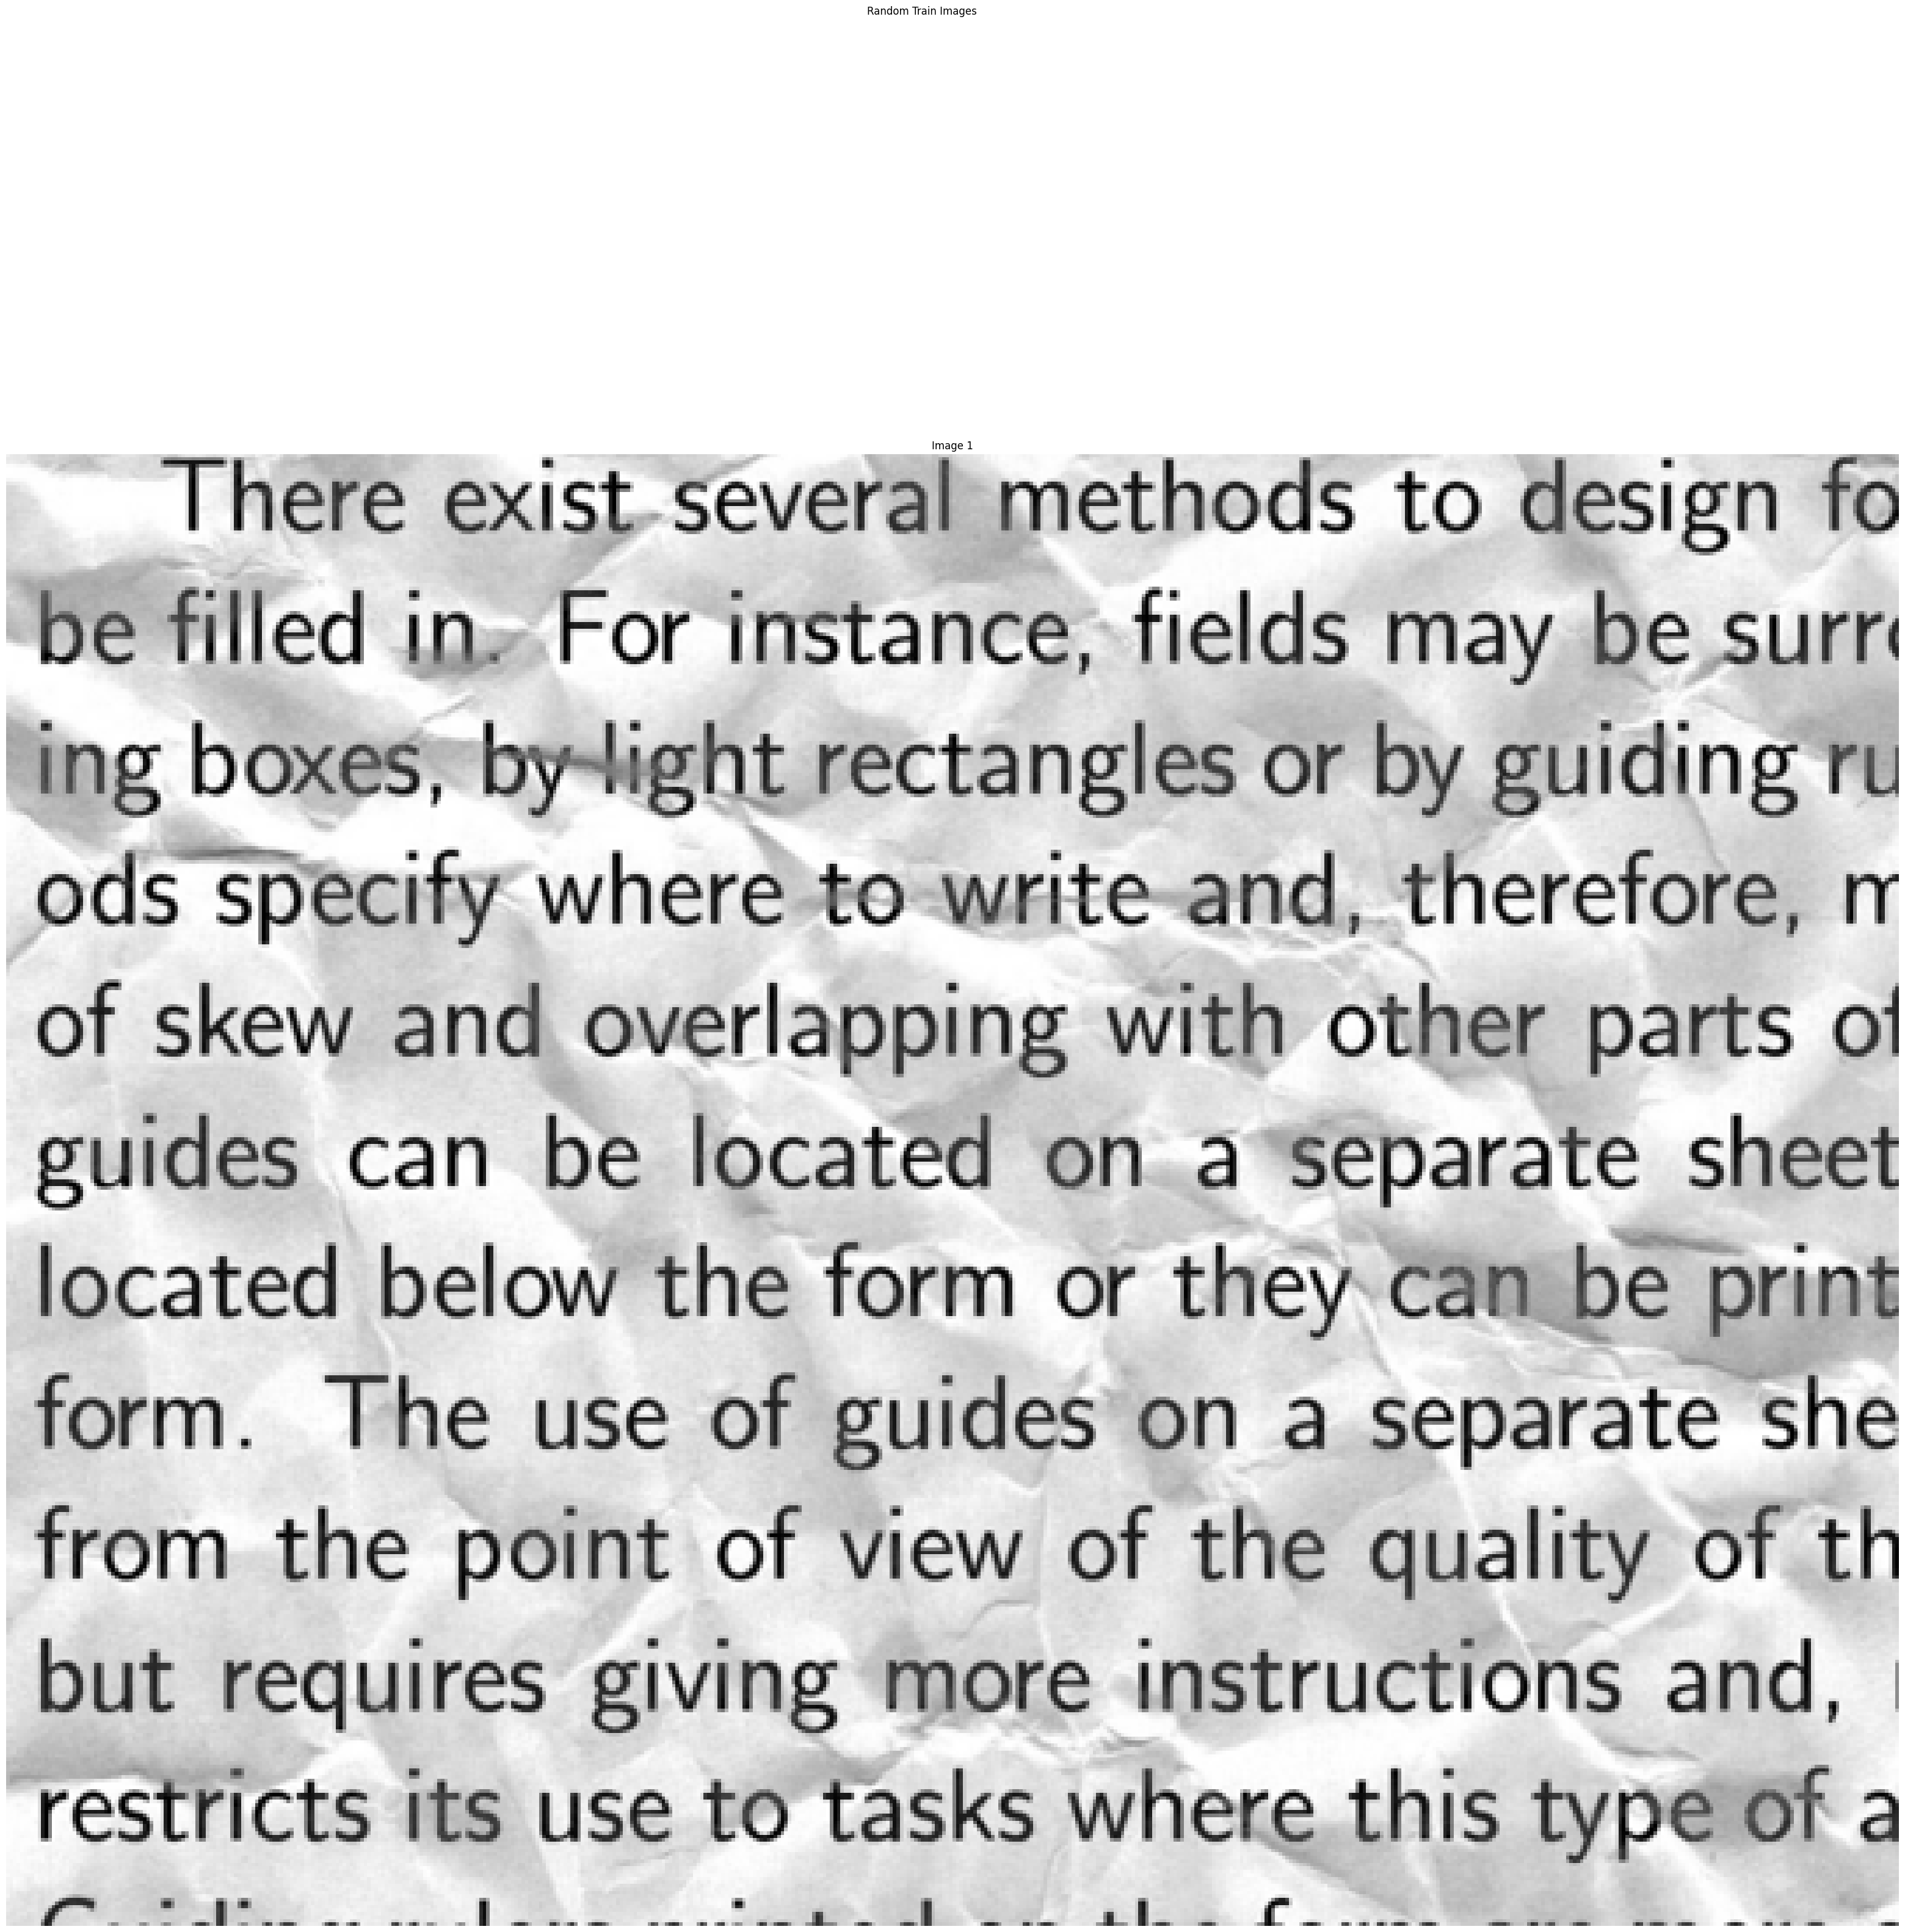

In [10]:
import random
import matplotlib.pyplot as plt
import cv2

def show_random_images(image_paths, num_images=5, title="Random Images"):
    """
    Displays random images from the provided list of image paths.

    :param image_paths: List of image paths
    :param num_images: Number of random images to display
    :param title: Title of the display
    """
    # Randomly select images
    selected_images = random.sample(image_paths, num_images)

    plt.figure(figsize=(40, 40))
    plt.suptitle(title)
    
    for i, image_path in enumerate(selected_images):
        # Read the image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        
        print(image.shape)
        
        # Display the image
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.title(f"Image {i + 1}")
        plt.axis("off")
    
    plt.show()

# Example usage: Display random images from the train dataset
show_random_images(train_images, num_images=1, title="Random Train Images")


# Image crop

In [11]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define paths
input_dirs = ['/kaggle/working/train_cleaned', '/kaggle/working/train', '/kaggle/working/test']
output_dirs = ['/kaggle/working/cropped_augmented/train_cleaned', '/kaggle/working/cropped_augmented/train', '/kaggle/working/cropped_augmented/test']

# Create output directories if they don't exist
for output_dir in output_dirs:
    os.makedirs(output_dir, exist_ok=True)

# Function to crop image into 4 pieces and resize to 256x256
def crop_and_resize(image, size=(256, 256)):
    height, width = image.shape[:2]
    mid_height, mid_width = height // 2, width // 2
    
    # Define coordinates for cropping
    crops = [
        (0, 0, mid_width, mid_height),            # Top-left
        (mid_width, 0, width, mid_height),        # Top-right
        (0, mid_height, mid_width, height),       # Bottom-left
        (mid_width, mid_height, width, height)    # Bottom-right
    ]
    
    cropped_resized_images = []
    for (x1, y1, x2, y2) in crops:
        cropped_image = image[y1:y2, x1:x2]
        resized_image = cv2.resize(cropped_image, size, interpolation=cv2.INTER_LINEAR)
        cropped_resized_images.append(resized_image)
    
    return cropped_resized_images

# Process images in each directory
for dir_path, output_dir in zip(input_dirs, output_dirs):
    for file_name in os.listdir(dir_path):
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            file_path = os.path.join(dir_path, file_name)
            
            # Load image
            image = load_img(file_path)
            image = img_to_array(image)
            
            # Crop and resize image
            cropped_resized_images = crop_and_resize(image)
            
            # Save cropped and resized images
            base_name, ext = os.path.splitext(file_name)
            for i, cropped_resized_image in enumerate(cropped_resized_images):
                output_file_path = os.path.join(output_dir, f"{base_name}_crop{i+1}{ext}")
                cv2.imwrite(output_file_path, cv2.cvtColor(cropped_resized_image, cv2.COLOR_RGB2BGR))

print("Cropping, resizing, and saving completed.")


Cropping, resizing, and saving completed.


# Encoder and decoder (uncropped)

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 512, 512, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 512, 512, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 256, 256, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_20 (UpSampling2D) │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 256, 256, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_21 (UpSampling2D) │ (None, 512, 512, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 512, 512, 1)    │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.2062 - val_loss: 0.1610
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 387ms/step - loss: 0.1512 - val_loss: 0.0969
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 389ms/step - loss: 0.0875 - val_loss: 0.0620
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 403ms/step - loss: 0.0591 - val_loss: 0.0673
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 429ms/step - loss: 0.0633 - val_loss: 0.0711
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 405ms/step - loss: 0.0671 - val_loss: 0.0721
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 408ms/step - loss: 0.0682 - val_loss: 0.0723
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 412ms/step - loss: 0.0679 - val_loss: 0.0724
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 398ms/step - loss: 0.0680 - val_loss: 0.0724
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 389ms/step - loss: 0.0688 - val_loss: 0.0725
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 403ms/step - loss: 0.0678 - val_loss: 0.0725
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 404ms/step - loss: 0.0682 - val_loss:

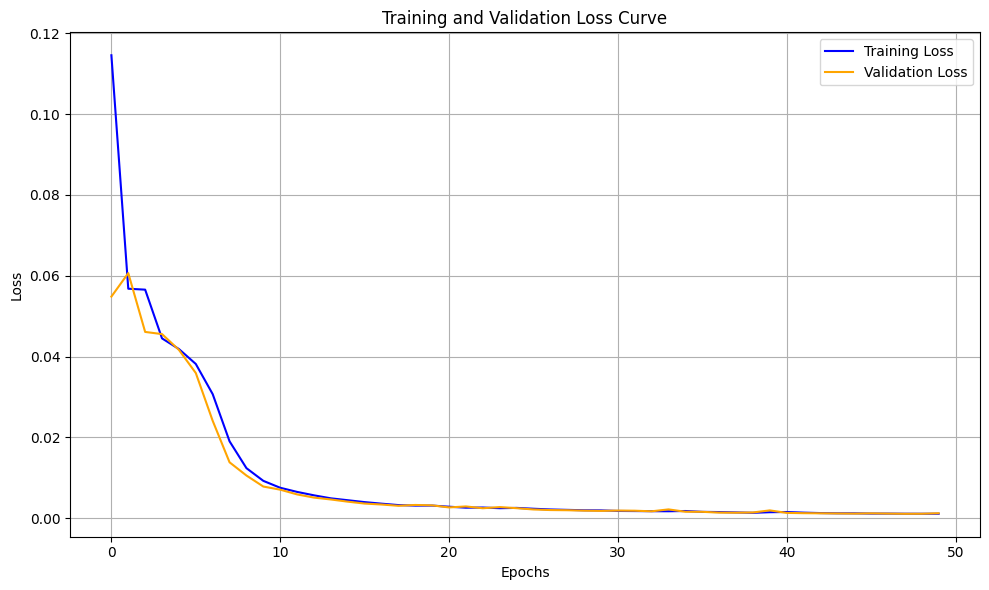

In [31]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import os
import cv2
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

# Function to load images from a directory and resize them
def load_images(directory, target_size=(512, 512)):
    images = []
    for file_name in os.listdir(directory):
        file_path = os.path.join(directory, file_name)
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
        image = cv2.resize(image, target_size)
        images.append(image)
    return np.array(images)

# Load data
train_cleaned_dir = '/kaggle/working/train_cleaned'
train_dir = '/kaggle/working/train'
test_dir = '/kaggle/working/test'

x_train_clean = load_images(train_cleaned_dir) / 255.0  # Normalize images
x_train_noisy = load_images(train_dir) / 255.0
x_test_noisy = load_images(test_dir) / 255.0

# Reshape images for the model
x_train_clean = x_train_clean.reshape(-1, 512, 512, 1)
x_train_noisy = x_train_noisy.reshape(-1, 512, 512, 1)
x_test_noisy = x_test_noisy.reshape(-1, 512, 512, 1)

# Build the autoencoder model
def build_autoencoder(input_shape=(512, 512, 1)):
    input_img = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    
    # Decoder
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = models.Model(input_img, decoded)
    autoencoder.summary()
    return autoencoder

autoencoder = build_autoencoder()

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the model
autoencoder.fit(x_train_noisy, x_train_clean, epochs=50, batch_size=64, validation_split=0.2)

# Denoise the test images
denoised_images = autoencoder.predict(x_test_noisy)

# Evaluate the model
def evaluate_model(denoised_images, x_test_noisy):
    mae = np.mean(np.abs(denoised_images - x_test_noisy))
    ssim_value = np.mean([ssim(denoised_images[i].reshape(512, 512), 
                               x_test_noisy[i].reshape(512, 512), 
                               data_range=1.0) for i in range(len(denoised_images))])
    return mae, ssim_value

mae, ssim_value = evaluate_model(denoised_images, x_test_noisy)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Structural Similarity Index (SSIM): {ssim_value}")

# Plot the learning curves for training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




# Encoder and Decoder (cropped)

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 512, 512, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 512, 512, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 256, 256, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_22 (UpSampling2D) │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 256, 256, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_23 (UpSampling2D) │ (None, 512, 512, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ (None, 512, 512, 1)    │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step  los
Epoch 1: MAE on Training Data: 0.1143
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 0.1361 - val_loss: 0.0561
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step- los
Epoch 2: MAE on Training Data: 0.1106
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 963ms/step - loss: 0.0562 - val_loss: 0.0613
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step- los
Epoch 3: MAE on Training Data: 0.1105
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 961ms/step - loss: 0.0593 - val_loss: 0.0613
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step- los
Epoch 4: MAE on Training Data: 0.1110
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 961ms/step - loss: 0.0596 - val_loss: 0.0579
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step- los
Epoch 5: MAE on Training Data: 0.1458
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 966ms/step - loss: 0.0522 - val_loss: 0.0441
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step- los
Epoch 6: MAE on Training Data: 0.1676
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 962ms/step - loss: 0.0437 - val_loss: 0.0435


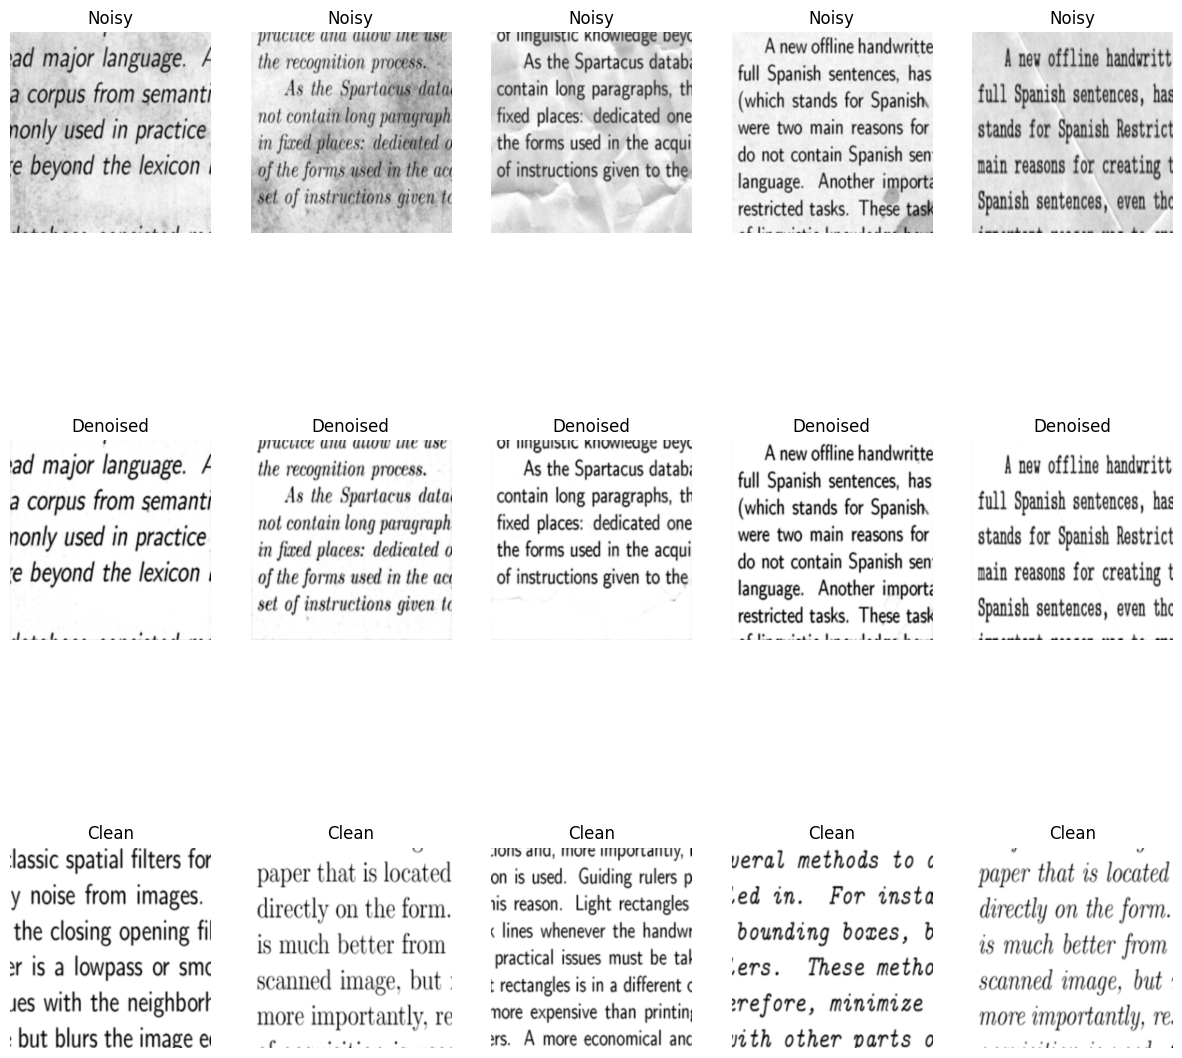

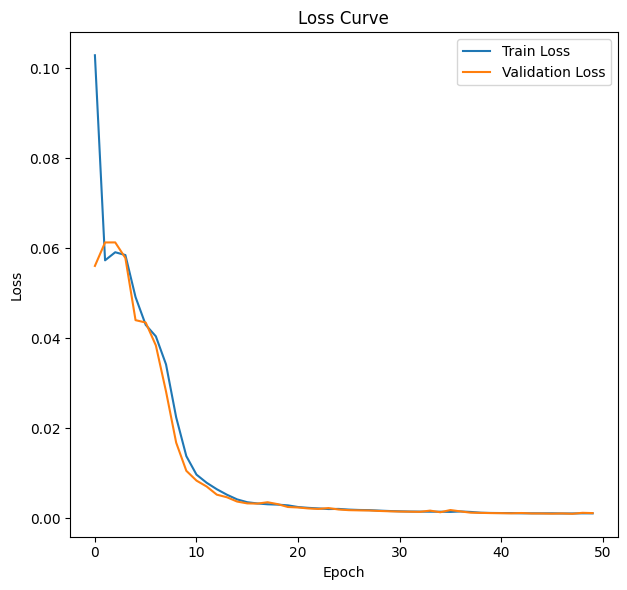

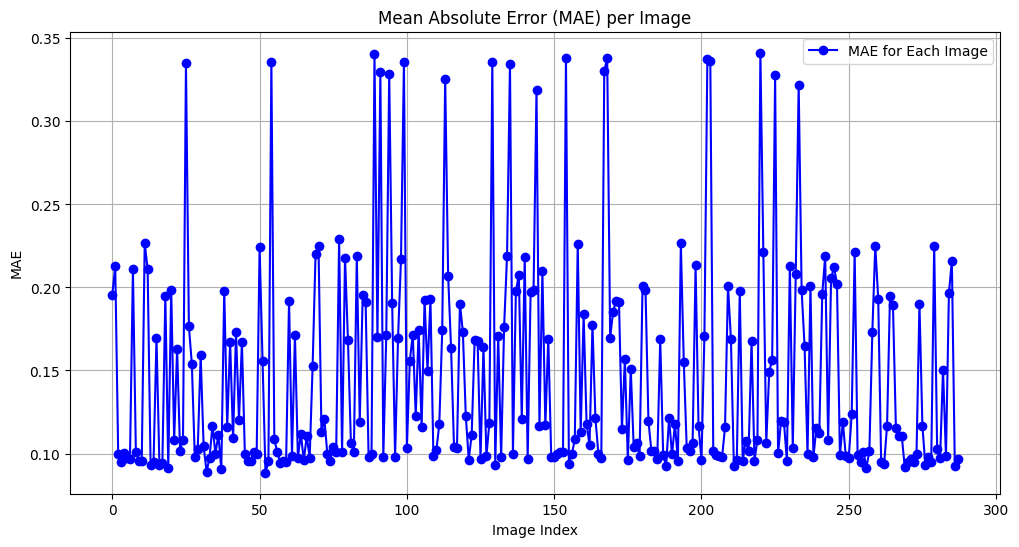

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import Callback
from skimage.metrics import structural_similarity as ssim

# Function to load images from a directory and resize them
def load_images(directory, target_size=(512, 512)):
    images = []
    for file_name in os.listdir(directory):
        file_path = os.path.join(directory, file_name)
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
        image = cv2.resize(image, target_size)
        images.append(image)
    return np.array(images)

# Load data
train_cleaned_dir = '/kaggle/working/cropped_augmented/train_cleaned'
train_dir = '/kaggle/working/cropped_augmented/train'
test_dir = '/kaggle/working/cropped_augmented/test'

x_train_clean = load_images(train_cleaned_dir) / 255.0  # Normalize images
x_train_noisy = load_images(train_dir) / 255.0
x_test_noisy = load_images(test_dir) / 255.0

# Reshape images for the model
x_train_clean = x_train_clean.reshape(-1, 512, 512, 1)
x_train_noisy = x_train_noisy.reshape(-1, 512, 512, 1)
x_test_noisy = x_test_noisy.reshape(-1, 512, 512, 1)

# Build the autoencoder model
def build_autoencoder(input_shape=(512, 512, 1)):
    input_img = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    
    # Decoder
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = models.Model(input_img, decoded)
    autoencoder.summary()
    return autoencoder

autoencoder = build_autoencoder()

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Custom callback to track MAE
class MAEHistory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(x_train_noisy)
        mae = np.mean(np.abs(y_pred - x_train_clean))
        print(f"Epoch {epoch + 1}: MAE on Training Data: {mae:.4f}")

# Initialize the custom callback
mae_history = MAEHistory()

# Train the model and capture the training history
history = autoencoder.fit(
    x_train_noisy, x_train_clean,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=[mae_history]
)

# Denoise the test images
denoised_images = autoencoder.predict(x_test_noisy)

# Evaluate the model
def evaluate_model(denoised_images, x_test_noisy):
    mae_values = np.mean(np.abs(denoised_images - x_test_noisy), axis=(1, 2, 3))
    ssim_value = np.mean([ssim(denoised_images[i].reshape(512, 512), 
                               x_test_noisy[i].reshape(512, 512), 
                               data_range=1.0) for i in range(len(denoised_images))])
    return mae_values, ssim_value

mae_values, ssim_value = evaluate_model(denoised_images, x_test_noisy)

print(f"Mean Absolute Error (MAE): {np.mean(mae_values)}")
print(f"Structural Similarity Index (SSIM): {ssim_value}")

# Visualize some results
n = 5  # number of images to visualize
plt.figure(figsize=(15, 15))
for i in range(n):
    # Display original noisy image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(512, 512), cmap="gray")
    plt.title("Noisy")
    plt.axis("off")
    
    # Display denoised image
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(denoised_images[i].reshape(512, 512), cmap="gray")
    plt.title("Denoised")
    plt.axis("off")
    
    # Display ground truth
    ax = plt.subplot(3, n, i + 1 + n * 2)
    plt.imshow(x_train_clean[i].reshape(512, 512), cmap="gray")
    plt.title("Clean")
    plt.axis("off")

plt.show()

# Plot learning curves
plt.figure(figsize=(12, 6))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Plot MAE values
plt.figure(figsize=(12, 6))
plt.plot(mae_values, label='MAE for Each Image', marker='o', linestyle='-', color='b')
plt.title('Mean Absolute Error (MAE) per Image')
plt.xlabel('Image Index')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()


In [34]:
# Save the entire model to a file
autoencoder.save('/kaggle/working/autoencoder_model.h5')

# Evaluation on test sets

In [29]:
from sklearn.metrics import confusion_matrix, accuracy_score

# Calculate reconstruction errors
reconstruction_errors = np.mean(np.abs(denoised_images - x_test_noisy), axis=(1, 2, 3))

# Set a threshold for classification
threshold = 0.1  # This is an example; you might need to tune this value

# Classify based on the threshold
y_true = np.ones(len(x_test_noisy))  # Assuming all images should be clean (this can be adapted based on actual labels)
y_pred = np.where(reconstruction_errors < threshold, 1, 0)  # Binary classification based on threshold

# Compute accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.3021
Confusion Matrix:
[[  0   0]
 [201  87]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


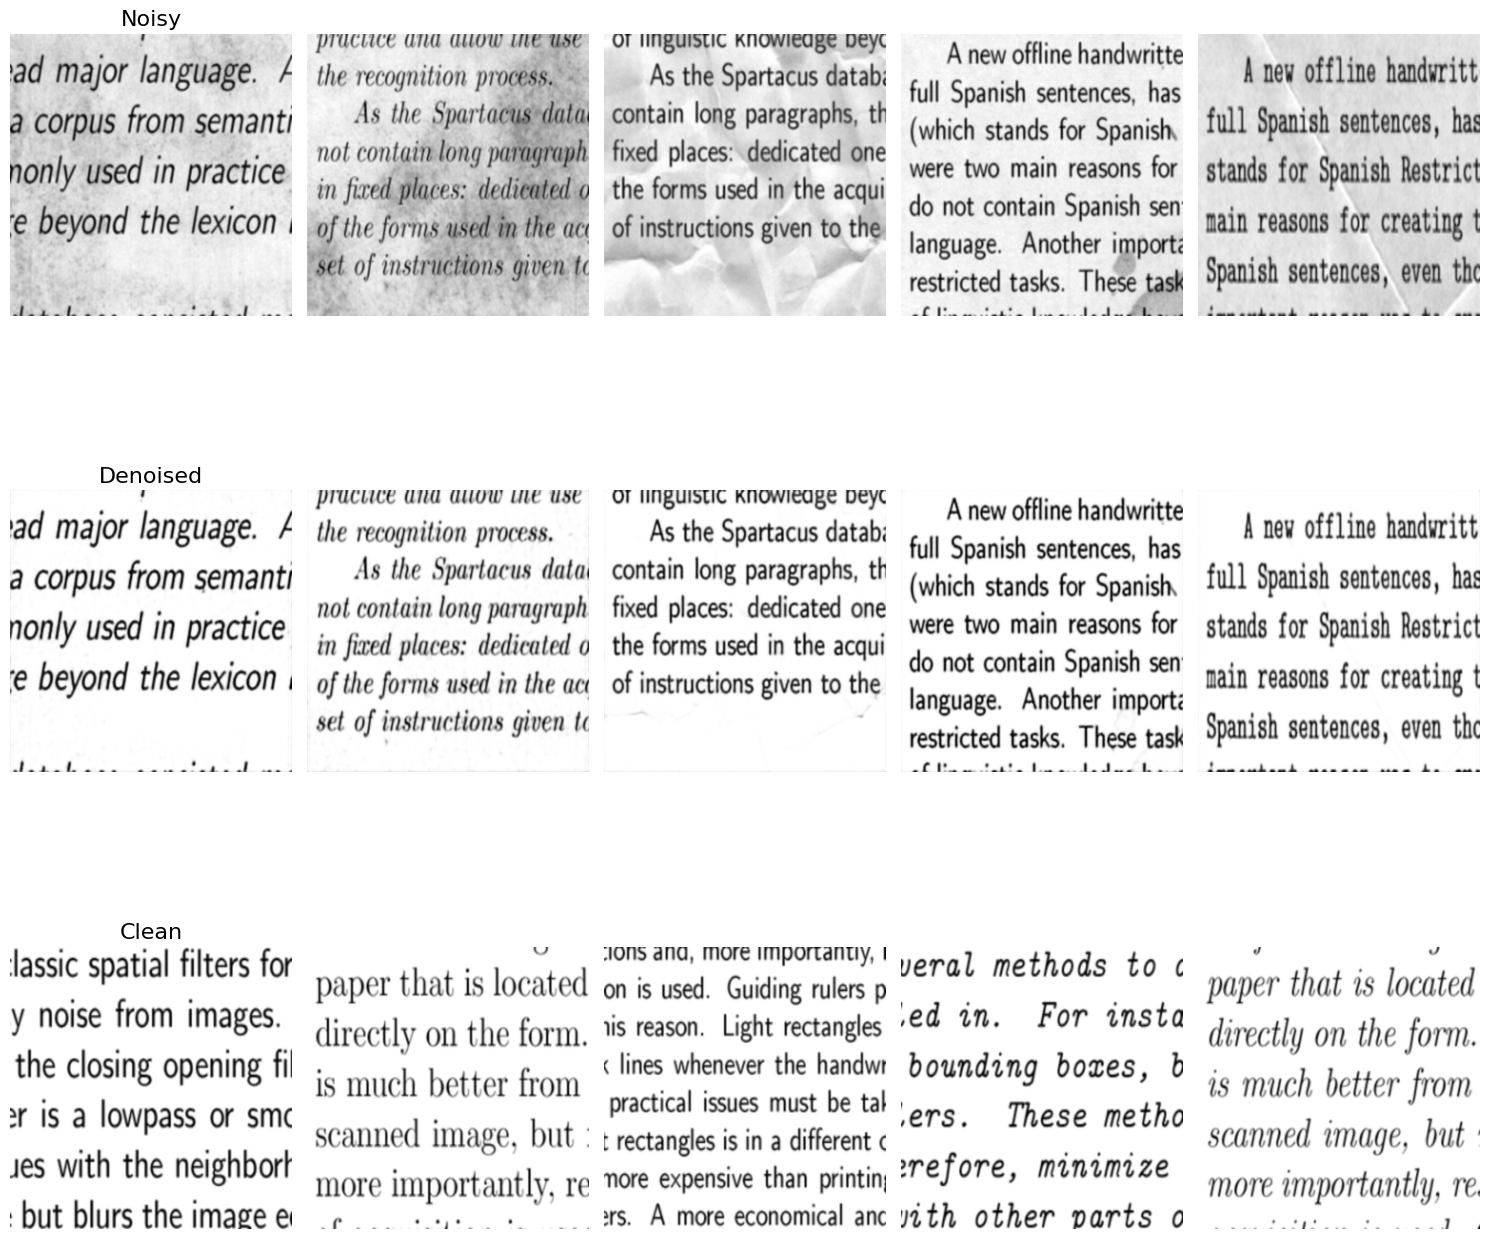

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Assuming x_test_noisy and x_train_clean are already defined
# Example data (replace these with your actual data)
# x_test_noisy = np.random.rand(100, 512, 512, 1)  # Noisy test images
# x_train_clean = np.random.rand(100, 512, 512, 1)  # Clean images

# Load the trained autoencoder model
autoencoder = load_model('autoencoder_model.h5', custom_objects={'mse': 'mean_squared_error'})

def display_results(noisy_images, clean_images, autoencoder, num_images=5):
    """
    Displays the noisy, denoised, and clean images side by side for comparison.

    :param noisy_images: Array of noisy images
    :param clean_images: Array of clean ground truth images
    :param autoencoder: Trained autoencoder model
    :param num_images: Number of images to display
    """
    # Use the autoencoder to predict denoised images
    denoised_images = autoencoder.predict(noisy_images[:num_images])
    
    plt.figure(figsize=(15, 15))
    
    for i in range(num_images):
        # Display noisy image
        ax = plt.subplot(3, num_images, i + 1)
        plt.imshow(noisy_images[i].reshape(512, 512), cmap="gray")
        if i == 0:
            plt.title("Noisy", fontsize=16)
        plt.axis("off")

        # Display denoised image
        ax = plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(denoised_images[i].reshape(512, 512), cmap="gray")
        if i == 0:
            plt.title("Denoised", fontsize=16)
        plt.axis("off")

        # Display clean image
        ax = plt.subplot(3, num_images, i + 1 + num_images * 2)
        plt.imshow(clean_images[i].reshape(512, 512), cmap="gray")
        if i == 0:
            plt.title("Clean", fontsize=16)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Example: Display the first 5 images with predictions
display_results(x_test_noisy, x_train_clean[:len(x_test_noisy)], autoencoder, num_images=5)
